In [31]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from utilities import compute_derivatives_2d, find_nearest_value
from solver_2d import false_transient_one_iteration_python

import matplotlib.pyplot as plt

The PDE is:

\begin{align*}
0 = \max_{\tilde{e}} \max_{\pi^a: \sum_{i=1}^n \pi^a_i = 1} & b \eta \log \tilde{e} + b\frac{\eta-1}{\delta}\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right] \tilde{e}  \sum_{i=1}^{n}\pi^a_i \theta_i\\
& + \frac{\partial V}{\partial y}\tilde{e} \sum_{i=1}^{n}\pi^a_i \theta_i - b \delta \frac{\partial V}{\partial b}\\
& + \frac{1}{2} \frac{\partial^2 V}{(\partial y)^2}|\sigma_y|^2(\tilde{e})^2 - \ell \tilde{e}\\
& + \frac{1}{2} b\frac{\eta-1}{\delta}\left[\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)\right]|\sigma_y|^2(\tilde{e})^2\\
& + \xi_a \sum_{i=1}^n \pi^a_i (\log \pi^a_i - \log \bar{\pi}^a_i)
\end{align*}

The FOC of $\tilde{e}$ gives:

$$
\tilde{e}^* = \frac{-\left[\sum_{i=1}^{n}\pi^a_i \theta_i G - \ell\right] - \sqrt{\left[ \sum_{i=1}^{n}\pi^a_i \theta_i G - \ell\right]^2-4b \eta |\sigma_y|^2F}}{2|\sigma_y|^2F}
$$

where $G:=\frac{\partial \tilde{V}}{\partial y} + b\frac{\eta-1}{\delta}\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]$, $F:=\frac{\partial^2 V}{(\partial y)^2} + b\frac{\eta-1}{\delta}\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)$.

The FOC of $\pi^a_i$ gives:

$$
\pi^a_i \propto \bar{\pi}^a_i \exp \left[-\frac{1}{\xi_a}G \tilde{e} \theta_i\right]
$$

In [22]:
def solve_pde_fixed_ell(y_grid, b_grid, ell, model_args=(), v0=None, ϵ=1.,
                        tol=1e-8, max_iter=5000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_a, γ_1, γ_2, γ_2p, y_bar = model_args
    Δ_y = y_grid[1] - y_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')

    if v0 is None:
        v0 = -η*(y_mat+y_mat**2)

    d_Λ = γ_1 + γ_2*y_mat + γ_2p*(y_mat>y_bar)*(y_mat-y_bar)
    dd_Λ = γ_2 + γ_2p*(y_mat>y_bar)

    πc = np.ones((len(πc_o), len(y_grid), len(b_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    bc = (np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0))
    impose_bc = (False, False, False, False)    

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy = compute_derivatives_2d(v0, 0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives_2d(v0, 0, 2, Δ_y)
        v0_db = compute_derivatives_2d(v0, 1, 1, Δ_b, central_diff=False)
        v0_dbb = compute_derivatives_2d(v0, 1, 2, Δ_b)        

        G = v0_dy + b_mat*(η-1)/δ*d_Λ
        F = v0_dyy + b_mat*(η-1)/δ*dd_Λ
        
        if σ_y == 0:
            e_tilde = -b_mat*η/(G*np.sum(πc*θ, axis=0)-ell)
        else:
            root = (np.sum(πc*θ, axis=0)*G - ell)**2 - 4*b_mat*η*σ_y**2*F
            root[root<0] = 0.
            e_tilde = (- (G*np.sum(πc*θ, axis=0)-ell) - np.sqrt(root)) / (2*σ_y**2*F)
        e_tilde[e_tilde<=0] = 1e-16

        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.zeros_like(y_mat)
        B_y = e_tilde * np.sum(πc*θ, axis=0)
        B_b = -b_mat*δ
        C_yy = .5 * σ_y**2 * e_tilde**2
        C_bb = np.zeros_like(b_mat)
        D = b_mat*η*np.log(e_tilde) + b_mat*(η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            -ell*e_tilde + .5*b_mat*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy
        v0 = false_transient_one_iteration_python(A, B_y, B_b, C_yy, C_bb, D, v0, ε, Δ_y, Δ_b, bc, impose_bc)

        rhs_error = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'πc': πc,
           'c_entropy': c_entropy}
    return res

In [44]:
def solve_pde_fixed_ell_jump(y_grid, b_grid, ell, model_args=(), v0=None, ϵ=1.,
                        tol=1e-8, max_iter=5000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_a, πd_o, ξ_p, γ_1, γ_2, y_bar, ϕ_i = model_args
    Δ_y = y_grid[1] - y_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')

    if v0 is None:
        v0 = -η*(y_mat+y_mat**2)

    d_Λ = γ_1 + γ_2*y_mat
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid), len(b_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd    

    πc = np.ones((len(πc_o), len(y_grid), len(b_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    count = 0
    error = 1.

    bc_y = -ξ_p*np.log(np.sum(πd_o[:, -1, :]*np.exp(-1./ξ_p*ϕ_i[:, -1, :]), axis=0))
    bc = (np.zeros(0), bc_y, np.zeros(0), np.zeros(0))
    impose_bc = (False, True, False, False)

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy = compute_derivatives_2d(v0, 0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives_2d(v0, 0, 2, Δ_y)
        v0_db = compute_derivatives_2d(v0, 1, 1, Δ_b, central_diff=False)
        v0_dbb = compute_derivatives_2d(v0, 1, 2, Δ_b)        

        G = v0_dy + b_mat*(η-1)/δ*d_Λ
        F = v0_dyy + b_mat*(η-1)/δ*dd_Λ
        
        if σ_y == 0:
            e_tilde = -b_mat*η/(G*np.sum(πc*θ, axis=0)-ell)
        else:
            root = (np.sum(πc*θ, axis=0)*G - ell)**2 - 4*b_mat*η*σ_y**2*F
            root[root<0] = 0.
            e_tilde = (- (G*np.sum(πc*θ, axis=0)-ell) - np.sqrt(root)) / (2*σ_y**2*F)
        e_tilde[e_tilde<=0] = 1e-16

        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.zeros_like(y_mat)
        B_y = e_tilde * np.sum(πc*θ, axis=0)
        B_b = -b_mat*δ
        C_yy = .5 * σ_y**2 * e_tilde**2
        C_bb = np.zeros_like(b_mat)
        D = b_mat*η*np.log(e_tilde) + b_mat*(η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            -ell*e_tilde + .5*b_mat*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy
        v0 = false_transient_one_iteration_python(A, B_y, B_b, C_yy, C_bb, D, v0, ε, Δ_y, Δ_b, bc, impose_bc)

        rhs_error = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'πc': πc,
           'c_entropy': c_entropy}
    return res

In [135]:
def compute_jump(ell):
    ξ_p = 5.
    ξ_a = .01

    η = .032
    δ = .01

    θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
    πc_o = np.ones_like(θ)/len(θ)
    σ_y = 1.2*np.mean(θ)

    y_bar = 2.
    γ_1 = 1.7675/10000
    γ_2 = .0022*2
    γ_2p = np.array([0, .0197*2, .3853*2])
    πd_o = np.array([1./3, 1./3, 1./3])

    y_step = .08
    y_grid_long = np.arange(0., 4., y_step)
    y_grid_short = np.arange(0., 2+y_step, y_step)
    n_bar = find_nearest_value(y_grid_long, y_bar) + 1

    b_step = .02
    b_grid = np.arange(b_step, 1+b_step, b_step)

    # Prepare ϕ_i
    model_res_list = []
    for γ_2p_i in γ_2p:
        model_args = (η, δ, θ, πc_o, σ_y, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
        model_res = solve_pde_fixed_ell(y_grid_long, b_grid, ell, model_args, v0=None, ϵ=1.,
                                        tol=1e-8, max_iter=1000, print_all=False)
        model_res_list.append(model_res)

    ϕ_list = [res['v0'] for res in model_res_list]

    ϕ_list_short = []
    for ϕ_i in ϕ_list:
        temp = ϕ_i[:n_bar, :]
        ϕ_list_short.append(temp)
    ϕ_i = np.array(ϕ_list_short)

    # Compute ϕ
    model_args = (η, δ, θ, πc_o, σ_y, ξ_a, πd_o, ξ_p, γ_1, γ_2, y_bar, ϕ_i)
    model_res = solve_pde_fixed_ell_jump(y_grid_short, b_grid, ell, model_args, 
                                         v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                         ϵ=1., tol=1e-8, max_iter=1000, print_all=False)
    return model_res

In [145]:
# ell = 1e-5 # 1400
# ell = 1e-3 # 1150
ell = 5e-3 # 1000
Δ_ell = ell/100.
model_ell = compute_jump(ell)
model_ell_right = compute_jump(ell+Δ_ell)

Converged. Total iteration 1000: LHS Error: 0.0008867498314439892; RHS Error 0.0008871795343021252
Converged. Total iteration 1000: LHS Error: 0.0008864459058486318; RHS Error 0.0011339818895822838
Converged. Total iteration 1000: LHS Error: 0.0008888831991444857; RHS Error 0.00679360828737767
Converged. Total iteration 1000: LHS Error: 0.004622257861723877; RHS Error 0.09069457099535318
Converged. Total iteration 1000: LHS Error: 0.0008867640432482782; RHS Error 0.0008872424492698747
Converged. Total iteration 1000: LHS Error: 0.000886467231575927; RHS Error 0.001131228688843548
Converged. Total iteration 1000: LHS Error: 0.0008887517669753375; RHS Error 0.006788506924422498
Converged. Total iteration 1000: LHS Error: 0.0016745268163456117; RHS Error 0.09067186993369256


In [146]:
ψ_ell = model_ell['v0'][:, -1]
ψ_ell_right = model_ell_right['v0'][:, -1]
dψ_ell = (ψ_ell_right-ψ_ell)/Δ_ell
r = -dψ_ell

In [147]:
def simulation(y_grid, e_grid, θ=1.86/1000., y_start=1., T=100):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt

In [148]:
y_grid = np.arange(0, 2+.08, .08)
et, _ = simulation(y_grid, model_ell['e_tilde'][:, -1])

In [149]:
r[13]

619.4653965954311

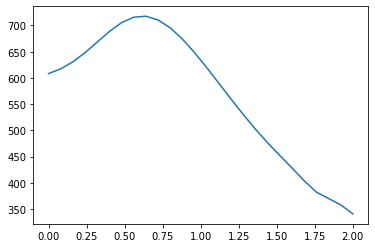

In [150]:
plt.plot(y_grid, r)

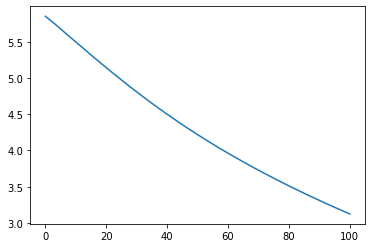

In [151]:
plt.plot(et)

## Compare results

In [136]:
# Compute no constraint version
model_ell_no_constraint = compute_jump(0)
# Compute total stock reserve = 1400
model_ell_1400 = compute_jump(1e-5)
# Compute total stock reserve = 1000
model_ell_1000 = compute_jump(5e-3)

Converged. Total iteration 1000: LHS Error: 0.0007585452428360284; RHS Error 0.0010318068106172223
Converged. Total iteration 1000: LHS Error: 0.0005004216360758873; RHS Error 0.0012350226683009932
Converged. Total iteration 1000: LHS Error: 0.00010699789044024688; RHS Error 0.007489000377484893
Converged. Total iteration 1000: LHS Error: 1.772644771819154e-05; RHS Error 0.004794174518458594
Converged. Total iteration 1000: LHS Error: 0.0007607946469008198; RHS Error 0.0010232743818599649
Converged. Total iteration 1000: LHS Error: 0.0005099361341602271; RHS Error 0.0012299569870225166
Converged. Total iteration 1000: LHS Error: 0.00011013711523302772; RHS Error 0.00748712436721688
Converged. Total iteration 1000: LHS Error: 8.892930290493872e-06; RHS Error 0.0047881264402724714
Converged. Total iteration 1000: LHS Error: 0.0008867498314439892; RHS Error 0.0008871795343021252
Converged. Total iteration 1000: LHS Error: 0.0008864459058486318; RHS Error 0.0011339818895822838
Converged. T

In [137]:
y_grid = np.arange(0, 2+.08, .08)
et_no_constraint, _ = simulation(y_grid, model_ell_no_constraint['e_tilde'][:, -1])
et_1400, _ = simulation(y_grid, model_ell_1400['e_tilde'][:, -1])
et_1000, _ = simulation(y_grid, model_ell_1000['e_tilde'][:, -1])

Text(0.5, 1.0, 'Emission trajectory')

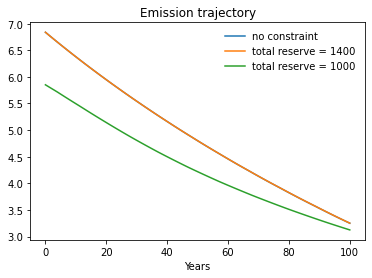

In [144]:
plt.plot(et_no_constraint, label='no constraint')
plt.plot(et_1400, label='total reserve = 1400')
plt.plot(et_1000, label='total reserve = 1000')
plt.legend(frameon=False)
plt.xlabel('Years')
plt.title('Emission trajectory')

In [152]:
θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

In [164]:
np.mean(θ)*1000

1.8619494444444442

In [154]:
σ_y

0.002234339333333333

In [155]:
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

In [160]:
η = .032
δ = .01

In [170]:
σ_y*1000/np.sqrt(50)

0.3159832988143659